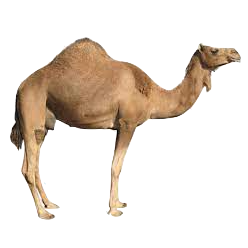

In [1]:
from IPython.display import Image as Image_colab
from IPython.display import display
from PIL import Image
import os

def mInput(prompt, default=None):
    prompt = f"{prompt} [{default}]: " if default else f"{prompt}: "
    response = input(prompt)
    return response if response else default

target_image = mInput("Image name:",default="camel.png")
abs_path = os.path.abspath(os.getcwd())
target_ = f"{abs_path}/target_images/{target_image}"
img_ = Image_colab(target_)
display(img_)

Processing [camel.png] ...


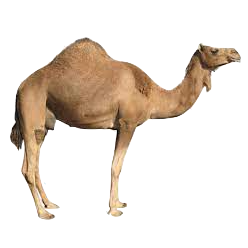

GPU: True, 0


In [2]:
import torch
gpunum=0

os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([f"{gpunum}"])
print("=" * 50)
print(f"Processing [{target_image}] ...")
img_ = Image_colab(target_)
display(img_)
print(f"GPU: {torch.cuda.is_available()}, {torch.cuda.current_device()}")
print("=" * 50)

In [3]:
seeds = 1001

from painterly_rendering import *

sys.argv = ['painterly_rendering.py', 'D:\\code\\CLIPasso/target_images/camel.png', '--num_paths', '16', '--output_dir', 'D:\\code\\CLIPasso/output_sketches/camel/', '--wandb_name', 'camel_16strokes_seed0', '--num_iter', '2001', '--save_interval', '10', '--seed', '0', '--use_gpu', '1', '--fix_scale', '0', '--mask_object', '0', '--mask_object_attention', '0', '--display_logs', '0', '--display', '0']

args = config.parse_arguments()
final_config = vars(args)

loss_func = Loss(args)
inputs, mask = get_target(args)

utils.log_input(args.use_wandb, 0, inputs, args.output_dir)
renderer = load_renderer(args, inputs, mask)

optimizer = PainterOptimizer(args, renderer)
counter = 0
configs_to_save = {"loss_eval": []}
best_loss, best_fc_loss = 100, 100
best_iter, best_iter_fc = 0, 0
min_delta = 1e-5
terminate = False

renderer.set_random_noise(0)
img = renderer.init_image(stage=0)
optimizer.init_optimizers()

if args.display:
    epoch_range = range(args.num_iter)
else:
    epoch_range = tqdm(range(args.num_iter))

for epoch in epoch_range:
    print(f"Epoch: {epoch}/{args.num_iter}")
    if not args.display:
        epoch_range.refresh()
    renderer.set_random_noise(epoch)
    if args.lr_scheduler:
        optimizer.update_lr(counter)

    start = time.time()
    optimizer.zero_grad_()
    sketches = renderer.get_image().to(args.device)
    print(sketches.shape)
    losses_dict = loss_func(sketches, inputs.detach(
    ), renderer.get_color_parameters(), renderer, counter, optimizer)
    loss = sum(list(losses_dict.values()))
    loss.backward()
    optimizer.step_()
    if epoch % args.save_interval == 0:
        utils.plot_batch(inputs, sketches, f"{args.output_dir}/jpg_logs", counter,
                            use_wandb=args.use_wandb, title=f"iter{epoch}.jpg")
        renderer.save_svg(
            f"{args.output_dir}/svg_logs", f"svg_iter{epoch}")
    if epoch % args.eval_interval == 0:
        with torch.no_grad():
            losses_dict_eval = loss_func(sketches, inputs, renderer.get_color_parameters(
            ), renderer.get_points_parans(), counter, optimizer, mode="eval")
            loss_eval = sum(list(losses_dict_eval.values()))
            configs_to_save["loss_eval"].append(loss_eval.item())
            for k in losses_dict_eval.keys():
                if k not in configs_to_save.keys():
                    configs_to_save[k] = []
                configs_to_save[k].append(losses_dict_eval[k].item())
            if args.clip_fc_loss_weight:
                if losses_dict_eval["fc"].item() < best_fc_loss:
                    best_fc_loss = losses_dict_eval["fc"].item(
                    ) / args.clip_fc_loss_weight
                    best_iter_fc = epoch
            # print(
            #     f"eval iter[{epoch}/{args.num_iter}] loss[{loss.item()}] time[{time.time() - start}]")

            cur_delta = loss_eval.item() - best_loss
            if abs(cur_delta) > min_delta:
                if cur_delta < 0:
                    best_loss = loss_eval.item()
                    best_iter = epoch
                    terminate = False
                    utils.plot_batch(
                        inputs, sketches, args.output_dir, counter, use_wandb=args.use_wandb, title="best_iter.jpg")
                    renderer.save_svg(args.output_dir, "best_iter")

            if args.use_wandb:
                wandb.run.summary["best_loss"] = best_loss
                wandb.run.summary["best_loss_fc"] = best_fc_loss
                wandb_dict = {"delta": cur_delta,
                                "loss_eval": loss_eval.item()}
                for k in losses_dict_eval.keys():
                    wandb_dict[k + "_eval"] = losses_dict_eval[k].item()
                wandb.log(wandb_dict, step=counter)

            if abs(cur_delta) <= min_delta:
                if terminate:
                    break
                terminate = True

    if counter == 0 and args.attention_init:
        utils.plot_atten(renderer.get_attn(), renderer.get_thresh(), inputs, renderer.get_inds(),
                            args.use_wandb, "{}/{}.jpg".format(
                                args.output_dir, "attention_map"),
                            args.saliency_model, args.display_logs)

    if args.use_wandb:
        wandb_dict = {"loss": loss.item(), "lr": optimizer.get_lr()}
        for k in losses_dict.keys():
            wandb_dict[k] = losses_dict[k].item()
        wandb.log(wandb_dict, step=counter)

    counter += 1





  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch: 0/2001
torch.Size([1, 3, 224, 224])
Epoch: 1/2001
torch.Size([1, 3, 224, 224])
Epoch: 2/2001
torch.Size([1, 3, 224, 224])
Epoch: 3/2001
torch.Size([1, 3, 224, 224])
Epoch: 4/2001
torch.Size([1, 3, 224, 224])
Epoch: 5/2001
torch.Size([1, 3, 224, 224])
Epoch: 6/2001
torch.Size([1, 3, 224, 224])
Epoch: 7/2001
torch.Size([1, 3, 224, 224])
Epoch: 8/2001
torch.Size([1, 3, 224, 224])
Epoch: 9/2001
torch.Size([1, 3, 224, 224])
Epoch: 10/2001
torch.Size([1, 3, 224, 224])
Epoch: 11/2001
torch.Size([1, 3, 224, 224])
Epoch: 12/2001
torch.Size([1, 3, 224, 224])
Epoch: 13/2001
torch.Size([1, 3, 224, 224])
Epoch: 14/2001
torch.Size([1, 3, 224, 224])
Epoch: 15/2001
torch.Size([1, 3, 224, 224])
Epoch: 16/2001
torch.Size([1, 3, 224, 224])
Epoch: 17/2001
torch.Size([1, 3, 224, 224])
Epoch: 18/2001
torch.Size([1, 3, 224, 224])
Epoch: 19/2001
torch.Size([1, 3, 224, 224])
Epoch: 20/2001
torch.Size([1, 3, 224, 224])
Epoch: 21/2001
torch.Size([1, 3, 224, 224])
Epoch: 22/2001
torch.Size([1, 3, 224, 224]

KeyboardInterrupt: 

In [16]:
print(renderer.render_warp().shape)

for points in renderer.control_points_set:
    for point in points:
        if point[0] > 224 or point[1] > 224:
            print(point)

torch.Size([224, 224, 4])
tensor([251.7066,  58.2013], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([246.6214,  71.6036], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([271.2713,  43.6202], device='cuda:0', grad_fn=<UnbindBackward0>)


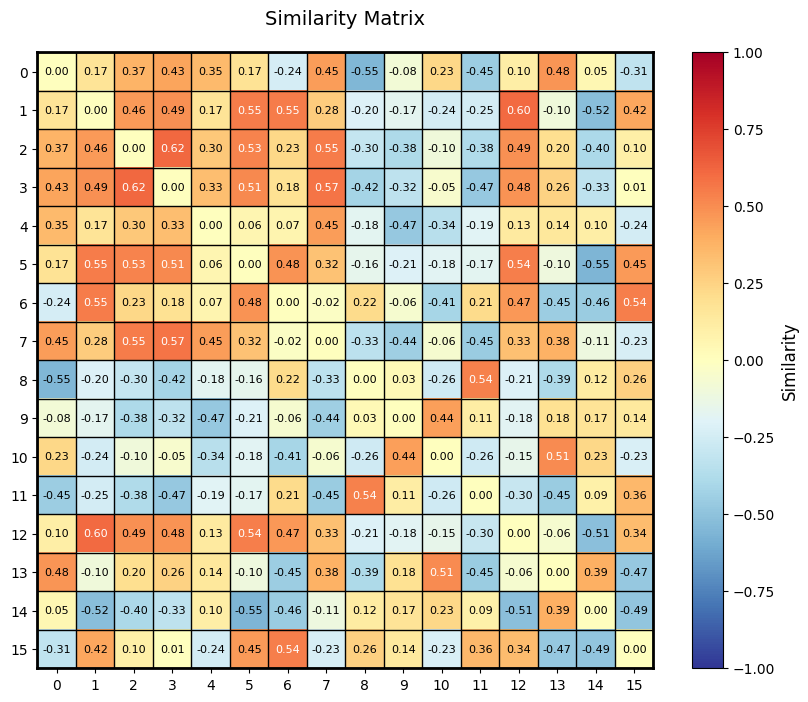

In [4]:
import torch
import matplotlib.pyplot as plt



import torch
import matplotlib.pyplot as plt

def computeCosineSimilarity(pointA: torch.Tensor, pointB: torch.Tensor):
    dot_product = torch.sum(pointA * pointB)
    norm_a = torch.sqrt(torch.sum(pointA * pointA))
    norm_b = torch.sqrt(torch.sum(pointB * pointB))
    eps = 1e-8
    return dot_product / (norm_a * norm_b + eps)

def getAttention(point: torch.Tensor, attention_map: torch.Tensor):
    h, w = attention_map.shape
    x, y = point[0], point[1]
    
    if x < 0 or x >= w or y < 0 or y >= h:
        return torch.tensor(0.0, device=point.device)
        

    x0, y0 = torch.floor(x).long(), torch.floor(y).long()
    x1, y1 = x0 + 1, y0 + 1
    
    x0 = torch.clamp(x0, 0, w-1)
    x1 = torch.clamp(x1, 0, w-1)
    y0 = torch.clamp(y0, 0, h-1)
    y1 = torch.clamp(y1, 0, h-1)
    
    wa = (x1.float() - x) * (y1.float() - y)
    wb = (x1.float() - x) * (y - y0.float())
    wc = (x - x0.float()) * (y1.float() - y)
    wd = (x - x0.float()) * (y - y0.float())
    
    return (wa * attention_map[y0, x0] + 
            wb * attention_map[y1, x0] +
            wc * attention_map[y0, x1] + 
            wd * attention_map[y1, x1])

def computePointsCosineSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor, use_diff: bool = True):
    assert len(pointsA) == len(pointsB)
    n = len(pointsA)
    
    # pointsA = pointsA[pointsA[:, 0].argsort()]
    # pointsB = pointsB[pointsB[:, 0].argsort()]
    
    if use_diff:
        diffA = pointsA[1:] - pointsA[:-1]
        diffB = pointsB[1:] - pointsB[:-1]
        vectors = zip(diffA, diffB)
        n = n - 1
    else:
        vectors = zip(pointsA, pointsB)
    
    cosine_sims = torch.stack([
        computeCosineSimilarity(vecA, vecB) 
        for vecA, vecB in vectors
    ])
    
    return cosine_sims.mean()

def computeAttentionSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor, attention_map: torch.Tensor):
    assert len(pointsA) == len(pointsB)
    
    attention_A = torch.stack([
        getAttention(p, attention_map) for p in pointsA
    ])
    attention_B = torch.stack([
        getAttention(p, attention_map) for p in pointsB
    ])
    
    att_mean_diff = torch.abs(attention_A.mean() - attention_B.mean())
    att_std_diff = torch.abs(attention_A.std() - attention_B.std())
    
    return att_mean_diff + 0.5 * att_std_diff

def computeAdjacencyMatrix(points_set: list, attention_map: torch.Tensor, use_diff: bool = True):
    num_points = len(points_set)
    device = points_set[0].device
    
    adjacency_matrix = torch.zeros((num_points, num_points), 
                                 dtype=torch.float32,
                                 device=device)
    
    for i in range(num_points):
        for j in range(num_points):
            if i == j:
                continue
                
            cos_sim = computePointsCosineSimilarity(
                points_set[i], 
                points_set[j],
                use_diff=use_diff
            )
            
            att_sim = computeAttentionSimilarity(
                points_set[i],
                points_set[j],
                attention_map
            )
            
            similarity = torch.tanh(scale_factor * (cos_sim * similar_weight + att_sim * attention_weight))
            adjacency_matrix[i, j] = similarity
            
    return adjacency_matrix

def visualize_adjacency_matrix(adjacency_matrix: torch.Tensor):
    """单独可视化邻接矩阵，并添加网格线
    
    Args:
        adjacency_matrix: 邻接矩阵
    """
    plt.figure(figsize=(10, 8))
    
    # 使用RdYlBu_r颜色映射
    im = plt.imshow(adjacency_matrix.cpu().detach().numpy(),
                   cmap='RdYlBu_r',  
                   vmin=-1,           
                   vmax=1,           
                   interpolation='nearest')
    
    # 添加网格线
    num_elements = adjacency_matrix.shape[0]
    
    # 添加垂直和水平线
    for i in range(num_elements + 1):
        plt.axvline(x=i - 0.5, color='black', linewidth=1)
        plt.axhline(y=i - 0.5, color='black', linewidth=1)
    
    # 添加颜色条
    cbar = plt.colorbar(im)
    cbar.set_label('Similarity', fontsize=12)
    
    # 添加数值标注
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            text_color = 'white' if adjacency_matrix[i,j] > 0.5 else 'black'
            plt.text(j, i, f'{adjacency_matrix[i,j]:.2f}',
                    ha='center', va='center',
                    color=text_color, fontsize=8)
    
    plt.title('Similarity Matrix', fontsize=14, pad=20)
    
    # 添加外边框
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    
    # 设置刻度
    plt.xticks(range(num_elements))
    plt.yticks(range(num_elements))
    plt.show()
    # plt.tight_layout()
    # plt.savefig("./saved_img/adjacency_matrix.png", 
    #             dpi=300,
    #             bbox_inches='tight',
    #             facecolor='white',
    #             edgecolor='none')
    # plt.close()

# class SimilarityModule(nn.Module):
#     def __init__(self):
#         super(SimilarityModule, self).__init__()
#         self.similar_weight = nn.Parameter(torch.tensor(0.7))
#         self.attention_weight = nn.Parameter(torch.tensor(0.2))
#         self.scale_factor = nn.Parameter(torch.tensor(10.0))

#     def forward(self, cos_sim: torch.Tensor, att_sim: torch.Tensor):
#         weights = F.softmax(torch.stack([self.similar_weight, self.attention_weight]), dim=0)
#         return torch.sigmoid(self.scale_factor * (weights[0] * cos_sim + weights[1] * att_sim))
    

# def train_similarity_weights():
#     pass

def clear_directory(directory, file_extension="*.png"):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        # 获取目录下所有指定扩展名的文件
        files = glob.glob(os.path.join(directory, file_extension))
        for file in files:
            try:
                os.remove(file)  # 删除文件
            except Exception as e:
                print(f"Error deleting file {file}: {e}")

#learnable parameters
similar_weight = 0.7
attention_weight = 0.2
scale_factor = 1
adjacency_matrix = computeAdjacencyMatrix(renderer.control_points_set, renderer.get_attn(), use_diff=True)
visualize_adjacency_matrix(adjacency_matrix)

In [16]:
print(renderer.shape_groups.__sizeof__())
print(renderer.shapes.__sizeof__())

168
168


In [48]:
def visualize_paths_and_matrix(adjacency_matrix, renderer, canvas_width, canvas_height):
    """可视化所有路径和邻接矩阵
    
    Args:
        adjacency_matrix: 邻接矩阵
        renderer: 渲染器对象
        canvas_width: 画布宽度
        canvas_height: 画布高度
    """
    num_paths = len(renderer.control_points_set)
    num_cols = 4  # 每行显示的路径数
    num_rows = (num_paths + num_cols - 1) // num_cols + 1  # 计算需要的行数(+1是为邻接矩阵)
    
    # 创建一个大图
    fig = plt.figure(figsize=(20, 5 * num_rows))
    
    # # 添加邻接矩阵子图
    # ax_matrix = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    # im = ax_matrix.imshow(adjacency_matrix.cpu().detach().numpy(), 
    #                      cmap='Blues', 
    #                      interpolation='nearest')
    # ax_matrix.set_title('Adjacency Matrix', fontsize=14, pad=20)
    # plt.colorbar(im, ax=ax_matrix)
    
    # # 为邻接矩阵添加边框
    # for spine in ax_matrix.spines.values():
    #     spine.set_edgecolor('black')
    #     spine.set_linewidth(2)
    
    # 绘制所有路径
    for path_idx in range(num_paths):
        row = (path_idx // num_cols) + 1  # +1 因为第一行是邻接矩阵
        col = path_idx % num_cols
        
        ax = plt.subplot2grid((num_rows, num_cols), (row, col))
        
        # 绘制当前路径
        points = renderer.control_points_set[path_idx]
        num_control_points = torch.zeros(renderer.num_segments, dtype=torch.int32) + (renderer.control_points_per_seg - 2)
        
        path = pydiffvg.Path(num_control_points=num_control_points,
                            points=points,
                            stroke_width=torch.tensor(1),
                            is_closed=False)
        shapes = [path]
        path_group = pydiffvg.ShapeGroup(shape_ids=torch.tensor([0]),
                                        fill_color=None,
                                        stroke_color=torch.tensor([0.0, 0.0, 0.0, 1.0]))
        shape_groups = [path_group]
        scene_args = pydiffvg.RenderFunction.serialize_scene(
            canvas_width, canvas_height, shapes, shape_groups
        )
        render = pydiffvg.RenderFunction.apply
        out = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)
        
        ax.imshow(out.cpu().detach().numpy(), interpolation="nearest")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.set_title(f"Path {path_idx}", fontsize=10, pad=10)
        
        # 为每个子图添加边框
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig("./saved_img/all_paths.png", 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    plt.close()

# 使用修改后的函数
canvas_width, canvas_height = renderer.attention_map.shape
pydiffvg.set_use_gpu(torch.cuda.is_available())

# 清理输出目录
clear_directory("./saved_img")

# 可视化所有路径和邻接矩阵
visualize_paths_and_matrix(adjacency_matrix, renderer, canvas_width, canvas_height)

print(f"Generated visualization with {len(renderer.control_points_set)} paths.")

Generated visualization with 16 paths.


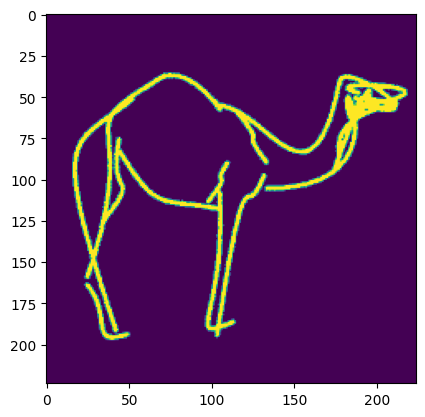

In [9]:
import pydiffvg
import matplotlib.pyplot as plt
canvas_width, canvas_height = renderer.attention_map.shape[0],renderer.attention_map.shape[1]
pydiffvg.set_use_gpu(torch.cuda.is_available())
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, renderer.shapes, renderer.shape_groups)
render = pydiffvg.RenderFunction.apply
out = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None,
             *scene_args)

plt.figure()

# atm = renderer.attention_map
# atm_tensor = torch.tensor(atm, device='cuda', dtype=torch.float32)
# 访问 out 的每个像素
# print(out.shape)
# 输出 (224,224,1)的值
# print(out[:,:,3])

# out[:, :, 3] = torch.where(out[:, :, 3] > 0, atm_tensor, out[:, :, 3])

plt.imshow(out[:,:,3].cpu().detach().numpy(),cmap='viridis')




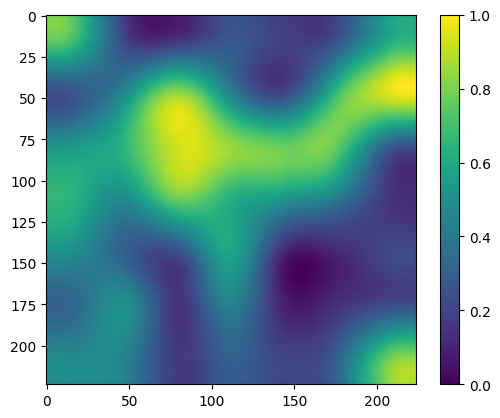

[[0.7972916  0.80018055 0.80258805 ... 0.61528736 0.6138429  0.61191696]
 [0.79969907 0.80258805 0.8049955  ... 0.6138429  0.61239845 0.61047244]
 [0.80210656 0.8049955  0.80740297 ... 0.61239845 0.610954   0.609028  ]
 ...
 [0.49395126 0.49443275 0.49443275 ... 0.88636774 0.8844418  0.8815528 ]
 [0.49346974 0.49346974 0.49395126 ... 0.8839603  0.8820343  0.8791453 ]
 [0.49250677 0.49298826 0.49298826 ... 0.8810713  0.87866384 0.8762564 ]]


In [7]:
import matplotlib.pyplot as plt

plt.imshow(renderer.attention_map,cmap='viridis')
plt.colorbar()
plt.show()
print(renderer.attention_map)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gcn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = gcn.GCNConv(in_channels, hidden_channels)
        self.conv2 = gcn.GCNConv(hidden_channels, out_channels)
        self.linear = nn.Linear(out_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return x

def graph_structure_loss(features, adjacency_matrix):
    cosine_sim = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=-1)

    structure_loss = torch.sum(adjacency_matrix * (1 - cosine_sim)) / adjacency_matrix.sum()
    return structure_loss

Gmodel = GCN(8, 16, 8).to('cuda')

optimizer = torch.optim.Adam(Gmodel.parameters(), lr=0.0001)
feature_matrix = torch.stack(renderer.control_points_set).to('cuda')
feature_matrix = feature_matrix.view(feature_matrix.shape[0], 8)
num_epochs = 100
for epoch in range(num_epochs):
    Gmodel.train()
    optimizer.zero_grad()

    out = Gmodel(feature_matrix, adjacency_matrix)

    structure_loss = graph_structure_loss(out, adjacency_matrix)

    loss = torch.mean(torch.sum(out ** 2, dim=1)) + 0.1 * structure_loss  

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Gmodel.eval()


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

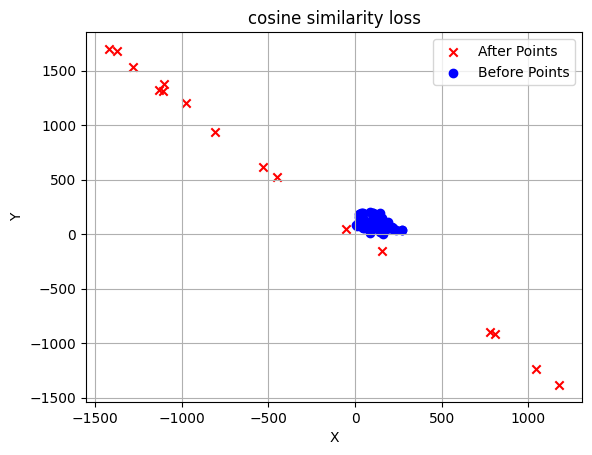

In [9]:
for points in renderer.control_points_set:
    # 每个点集有 4 个点，分别提取这些点的坐标
    x_coords = points[:, 0].cpu().detach().numpy()  # x 坐标
    y_coords = points[:, 1].cpu().detach().numpy()  # y 坐标

    # 使用不同颜色或标记绘制每个点集
    plt.scatter(x_coords, y_coords, color='blue', marker='o')  # 用圆形表示之前的点
with torch.no_grad():
    out = Gmodel(feature_matrix, adjacency_matrix)
    #control points set
    x_af = out[:, 0].cpu().detach().numpy()
    y_af = out[:, 1].cpu().detach().numpy()

plt.scatter(x_af,y_af, color='red', marker='x', label="After Points")
plt.scatter(x_coords, y_coords, color='blue', marker='o', label="Before Points")
plt.xlabel('X')
plt.ylabel('Y')
# 显示图例
plt.legend()

# 显示网格
plt.grid(True)
plt.title('cosine similarity loss')

# 显示图形
plt.show()

C:\Users\sentuix\AppData\Local\Temp\ipykernel_54196\3537894187.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow')


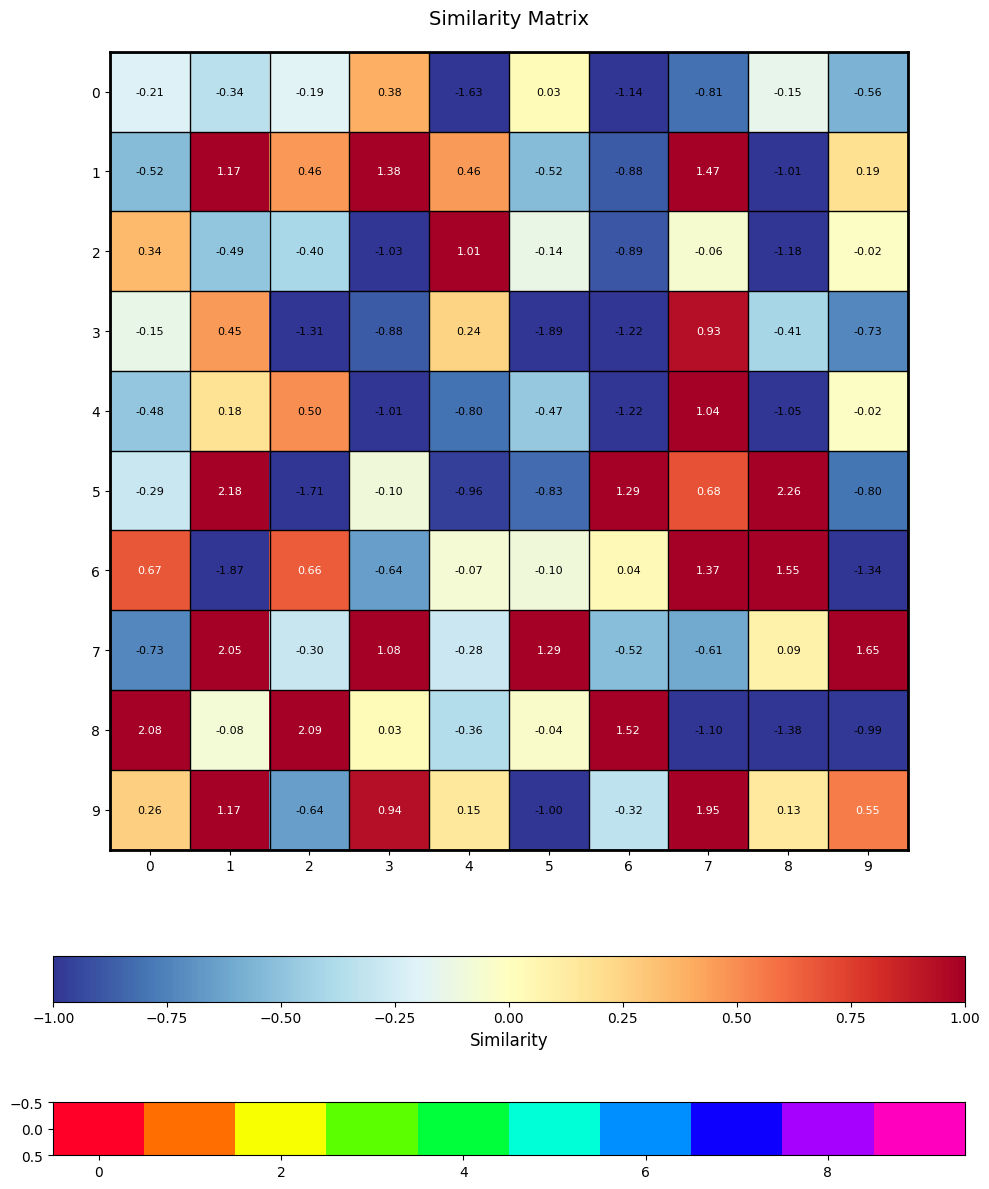

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

# 全局数组，用于存储颜色映射
color_array = []

def visualize_adjacency_matrix(adjacency_matrix: torch.Tensor):
    """单独可视化邻接矩阵，并添加网格线及横向颜色条
    
    Args:
        adjacency_matrix: 邻接矩阵
    """
    num_elements = adjacency_matrix.shape[0]
    
    # 创建一个2行1列的布局，第一行为邻接矩阵，第二行为颜色条
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 0.05]})
    
    # 设置第一个子图：邻接矩阵
    im = ax[0].imshow(adjacency_matrix.cpu().detach().numpy(),
                      cmap='RdYlBu_r',
                      vmin=-1,
                      vmax=1,
                      interpolation='nearest')
    
    # 添加网格线
    for i in range(num_elements + 1):
        ax[0].axvline(x=i - 0.5, color='black', linewidth=1)
        ax[0].axhline(y=i - 0.5, color='black', linewidth=1)
    
    # 添加数值标注
    for i in range(num_elements):
        for j in range(num_elements):
            text_color = 'white' if adjacency_matrix[i, j] > 0.5 else 'black'
            ax[0].text(j, i, f'{adjacency_matrix[i, j]:.2f}',
                       ha='center', va='center',
                       color=text_color, fontsize=8)
    
    # 设置刻度，间隔为1
    ax[0].set_xticks(range(num_elements))
    ax[0].set_yticks(range(num_elements))
    ax[0].set_xticklabels(range(num_elements))
    ax[0].set_yticklabels(range(num_elements))
    ax[0].set_title('Similarity Matrix', fontsize=14, pad=20)
    
    # 添加外边框
    for spine in ax[0].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # 创建横向颜色条并将颜色映射存储到color_array
    norm = Normalize(vmin=0, vmax=num_elements - 1)
    cmap = cm.get_cmap('gist_rainbow')
    color_array[:] = [cmap(norm(i)) for i in range(num_elements)]  # 将颜色映射保存到color_array
    
    # 设置第二个子图：横向颜色条
    ax[1].imshow([np.linspace(0, 1, num_elements)], aspect='auto', cmap='gist_rainbow')
    # ax[1].set_axis_off()  # 不显示坐标轴
    
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.1)
    cbar.set_label('Similarity', fontsize=12)
    
    # 显示图形
    plt.tight_layout()
    plt.show()

# 示例调用
adjacency_matrix = torch.randn(10, 10)  # 创建一个10x10的随机矩阵
visualize_adjacency_matrix(adjacency_matrix)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from gcn import GCN

in_channels = 5
hidden_channels = 10
out_channels = 5

control_points_set = [torch.randn(4 , 2)] * 16  # 10 个点，每个点有 5 个维度
attention_map = torch.randn(100, 100)  # 假设 attention_map 是 100x100 的矩阵
canvas_width = 100
canvas_height = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(in_channels, hidden_channels, out_channels, control_points_set, attention_map, canvas_width, canvas_height, device)

# 查看初始化的共享特征矩阵和邻接矩阵
print("Shared Features Matrix:\n", model.get_feature_matrix())
print("Shared Adjacency Matrix:\n", model.get_adj_matrix())

# 测试前向传播
output = model()
print("GCN Output:\n", output)

# 查看梯度
output.sum().backward()  # 计算损失并反向传播
print("Gradient of Shared Features:\n", model.control_points_set.grad)


AttributeError: 'list' object has no attribute 'detach'